 # DL Assignment 5

-------------------------------------------------------------------------------

### Topic: Implementing Custom Deep Neural Networks And Pre-Trained Models 

Name: Priyanka Nandkumar Gaikwad

Roll no: 23

PRN: 12210124

Dogs and cat Classification (classification): https://www.kaggle.com/datasets/salader/dogs-vs-cats



In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, MobileNetV2, InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Load Data into train-test-val splits

In [2]:
# Download and setup dataset
path = kagglehub.dataset_download("salader/dogs-vs-cats")
print("Path to dataset files:", path)

base_path = "/kaggle/input/dogs-vs-cats"
original_train = os.path.join(base_path, "train")
original_test = os.path.join(base_path, "test")

# Parameters
img_size = (150, 150)
batch_size = 32

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    original_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

val_generator = val_datagen.flow_from_directory(
    original_train,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    original_test,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

class_names = list(train_generator.class_indices.keys())


Path to dataset files: /kaggle/input/dogs-vs-cats
Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## EDA

Class names: ['cats', 'dogs']
Number of training samples: 16000
Number of validation samples: 4000
Number of test samples: 5000

Training samples:


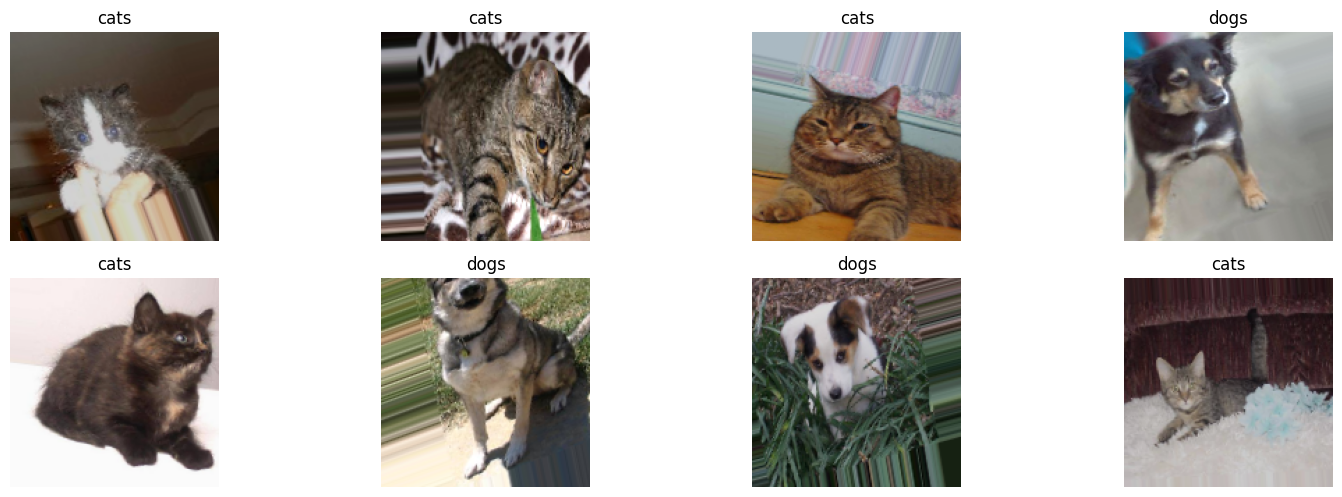


Validation samples:


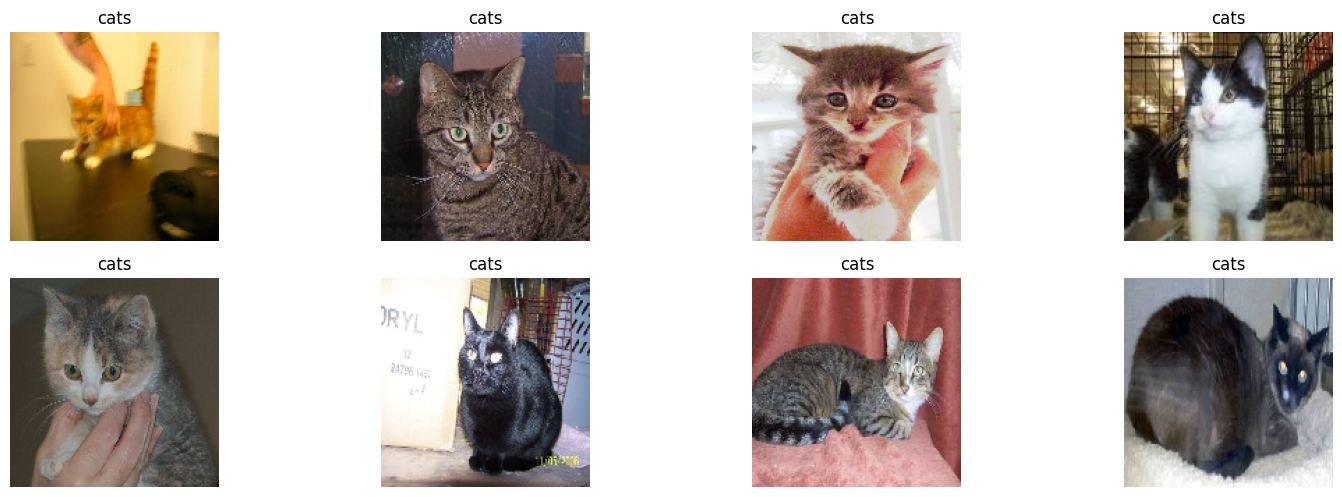

In [7]:
# EDA: Check dataset statistics
print("Class names:", class_names)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)
print("Number of test samples:", test_generator.samples)

# Visualize sample images
def plot_sample_images(generator, num_images=8):
    plt.figure(figsize=(15, 10))
    images, labels = next(generator)
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nTraining samples:")
plot_sample_images(train_generator)

print("\nValidation samples:")
plot_sample_images(val_generator)

In [11]:
# 1. VGG16 Frozen
print("\nTraining VGG16 (Frozen)...")
vgg16_frozen = Sequential([
    VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Freeze base model
for layer in vgg16_frozen.layers[0].layers:
    layer.trainable = False

vgg16_frozen.compile(optimizer=Adam(1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

history_vgg16_frozen = vgg16_frozen.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)




Training VGG16 (Frozen)...
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 156s 308ms/step - accuracy: 0.7437 - loss: 0.5056 - val_accuracy: 0.8925 - val_loss: 0.2548
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 152s 303ms/step - accuracy: 0.8426 - loss: 0.3449 - val_accuracy: 0.8970 - val_loss: 0.2452
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 201s 302ms/step - accuracy: 0.8556 - loss: 0.3229 - val_accuracy: 0.9003 - val_loss: 0.2318
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 154s 307ms/step - accuracy: 0.8616 - loss: 0.3114 - val_accuracy: 0.9103 - val_loss: 0.2201
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 152s 303ms/step - accuracy: 0.8687 - loss: 0.2984 - val_accuracy: 0.9103 - val_loss: 0.2163


In [13]:
# 2. VGG16 Partial Unfrozen
print("\nTraining VGG16 (4 Layers Unfrozen)...")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Unfreeze last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

vgg16_unfrozen = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

vgg16_unfrozen.compile(optimizer=Adam(1e-4),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_vgg16_unfrozen = vgg16_unfrozen.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)


Training VGG16 (4 Layers Unfrozen)...
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 171s 314ms/step - accuracy: 0.8076 - loss: 0.3972 - val_accuracy: 0.8845 - val_loss: 0.3205
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 199s 311ms/step - accuracy: 0.9127 - loss: 0.2039 - val_accuracy: 0.9358 - val_loss: 0.1574
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 310ms/step - accuracy: 0.9335 - loss: 0.1605 - val_accuracy: 0.9495 - val_loss: 0.1311
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 310ms/step - accuracy: 0.9445 - loss: 0.1329 - val_accuracy: 0.9538 - val_loss: 0.1171
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 310ms/step - accuracy: 0.9546 - loss: 0.1165 - val_accuracy: 0.9505 - val_loss: 0.1305


In [15]:
from tensorflow.keras.applications import MobileNet

# 3. MobileNet
print("\nTraining MobileNet...")
mobilenet = Sequential([
    MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Freeze base model
for layer in mobilenet.layers[0].layers:
    layer.trainable = False

mobilenet.compile(optimizer=Adam(1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_mobilenet = mobilenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)




Training MobileNet...


<ipython-input-15-af570e7a2d83>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 271ms/step - accuracy: 0.8883 - loss: 0.4698 - val_accuracy: 0.9672 - val_loss: 0.0834
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 132s 263ms/step - accuracy: 0.9494 - loss: 0.1298 - val_accuracy: 0.9670 - val_loss: 0.0784
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 268ms/step - accuracy: 0.9532 - loss: 0.1178 - val_accuracy: 0.9725 - val_loss: 0.0725
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 266ms/step - accuracy: 0.9587 - loss: 0.1037 - val_accuracy: 0.9730 - val_loss: 0.0715
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 268ms/step - accuracy: 0.9602 - loss: 0.1063 - val_accuracy: 0.9735 - val_loss: 0.0698


In [16]:
from tensorflow.keras.applications import InceptionV3

# 4. InceptionV3
print("\nTraining InceptionV3...")
inception = Sequential([
    InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Freeze base model
for layer in inception.layers[0].layers:
    layer.trainable = False

inception.compile(optimizer=Adam(1e-4),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_inception = inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)




Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 286ms/step - accuracy: 0.8886 - loss: 0.4843 - val_accuracy: 0.9567 - val_loss: 0.1025
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - accuracy: 0.9340 - loss: 0.1631 - val_accuracy: 0.9625 - val_loss: 0.0939
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 279ms/step - accuracy: 0.9438 - loss: 0.1390 - val_accuracy: 0.9597 - val_loss: 0.1015
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - accuracy: 0.9461 - loss: 0.1338 - val_accuracy: 0.9617 - val_loss: 0.0930
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 278ms/step - accuracy: 0.9423 - loss: 0.1339 - val_accuracy: 0.9650 - val_loss: 0.0901


In [17]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# 5. LeNet
print("\nTraining LeNet...")
lenet = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

lenet.compile(optimizer=Adam(1e-4),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history_lenet = lenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)




Training LeNet...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 269ms/step - accuracy: 0.5481 - loss: 0.6845 - val_accuracy: 0.6920 - val_loss: 0.5953
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 266ms/step - accuracy: 0.6542 - loss: 0.6207 - val_accuracy: 0.7398 - val_loss: 0.5351
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 265ms/step - accuracy: 0.6799 - loss: 0.5891 - val_accuracy: 0.7577 - val_loss: 0.5024
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 268ms/step - accuracy: 0.6977 - loss: 0.5764 - val_accuracy: 0.7550 - val_loss: 0.5073
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 267ms/step - accuracy: 0.7126 - loss: 0.5510 - val_accuracy: 0.7807 - val_loss: 0.4707


In [18]:
# 6. AlexNet
print("\nTraining AlexNet...")
alexnet = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(256, (5, 5), activation='relu', padding='same'),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

alexnet.compile(optimizer=Adam(1e-4),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history_alexnet = alexnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)




Training AlexNet...
Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 277ms/step - accuracy: 0.5112 - loss: 0.6933 - val_accuracy: 0.5013 - val_loss: 0.6927
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 270ms/step - accuracy: 0.5283 - loss: 0.6890 - val_accuracy: 0.6058 - val_loss: 0.6526
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 270ms/step - accuracy: 0.6223 - loss: 0.6502 - val_accuracy: 0.6423 - val_loss: 0.6337
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 136s 272ms/step - accuracy: 0.6691 - loss: 0.6082 - val_accuracy: 0.7442 - val_loss: 0.5188
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 269ms/step - accuracy: 0.7224 - loss: 0.5516 - val_accuracy: 0.7878 - val_loss: 0.4529


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical

def evaluate_model(model, model_name, generator, history=None):
    """
    Comprehensive evaluation of a classification model
    Args:
        model: Trained Keras model
        model_name: String name for plots
        generator: Data generator (validation/test)
        history: Training history object (optional)
    Returns:
        Dictionary containing evaluation metrics including:
        - accuracy
        - loss
        - precision
        - recall
        - f1_score
        - auc (for binary classification)
        - confusion_matrix
    """
    # Reset generator and get true labels
    generator.reset()
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())

    # Predict probabilities and classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # 1. Classification Report
    print(f"\n{'='*40}")
    print(f"Evaluation for {model_name}")
    print(f"{'='*40}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # 2. Confusion Matrix
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # 3. ROC Curve (handles binary and multi-class)
    plt.figure(figsize=(8, 6))
    roc_auc = None
    if len(class_names) == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:  # Multi-class classification
        for i, class_name in enumerate(class_names):
            RocCurveDisplay.from_predictions(
                to_categorical(y_true)[:, i],
                y_pred[:, i],
                name=f"{class_name} vs Rest",
                ax=plt.gca()
            )
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve(s) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Training History (if available)
    if history is not None:
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.title(f'{model_name} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{model_name} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Calculate metrics
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    # Return metrics for comparison
    metrics = {
        'accuracy': np.mean(y_true == y_pred_classes),
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'loss': model.evaluate(generator, verbose=0)[0],
        'confusion_matrix': cm
    }

    if len(class_names) == 2:
        metrics['auc'] = roc_auc

    return metrics

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step

Evaluation for VGG16 (Frozen)

Classification Report:
              precision    recall  f1-score   support

        cats       0.92      0.90      0.91      2000
        dogs       0.91      0.92      0.91      2000

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



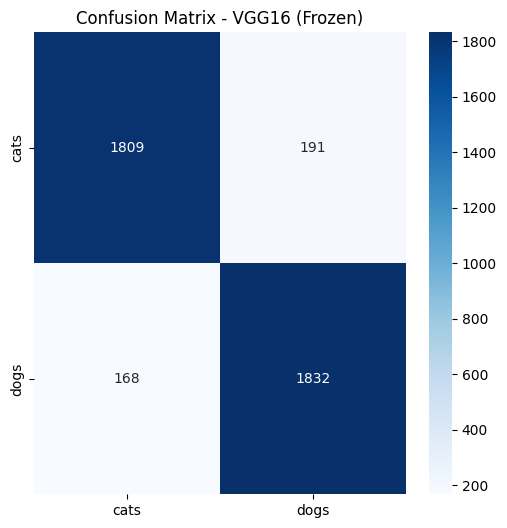

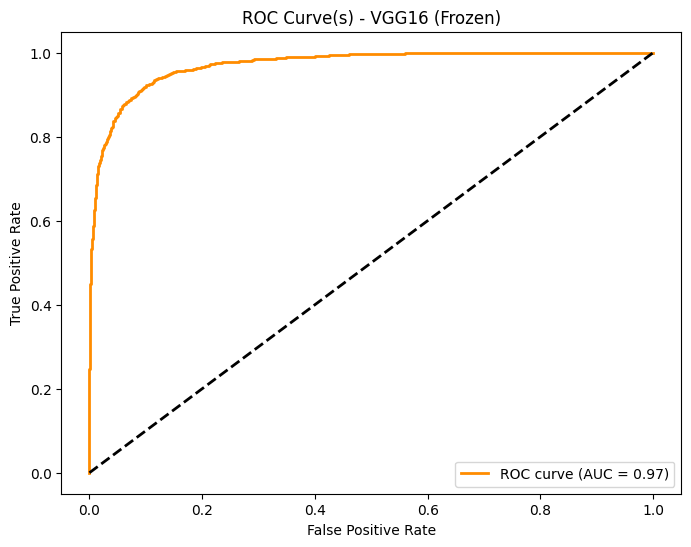

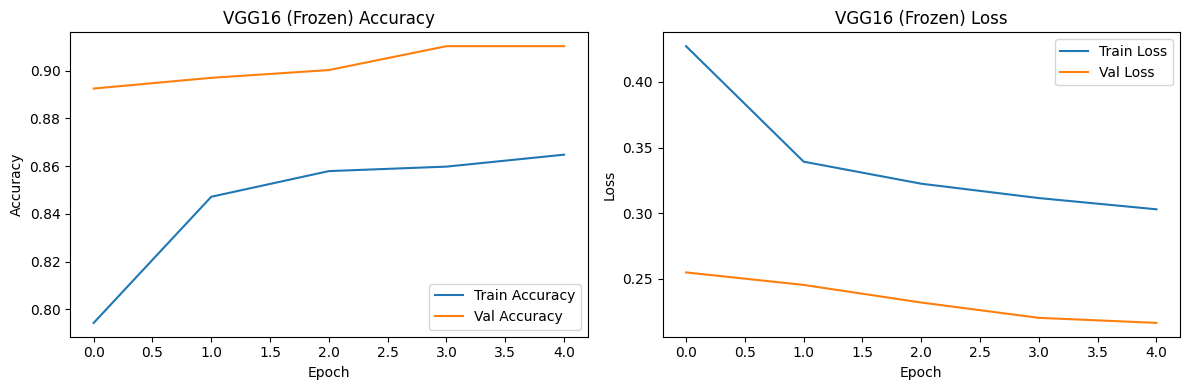

In [39]:
# Evaluation
vgg16_frozen_metrics = evaluate_model(
    vgg16_frozen,
    "VGG16 (Frozen)",
    val_generator,
    history_vgg16_frozen
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step

Evaluation for VGG16 (4 Layers Unfrozen)

Classification Report:
              precision    recall  f1-score   support

        cats       0.94      0.96      0.95      2000
        dogs       0.96      0.94      0.95      2000

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



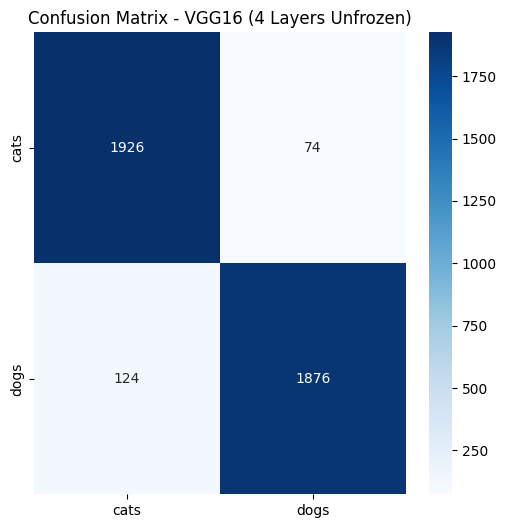

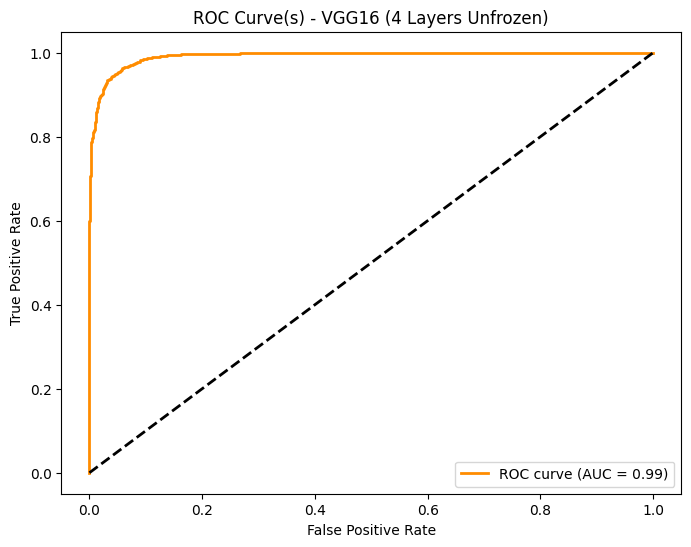

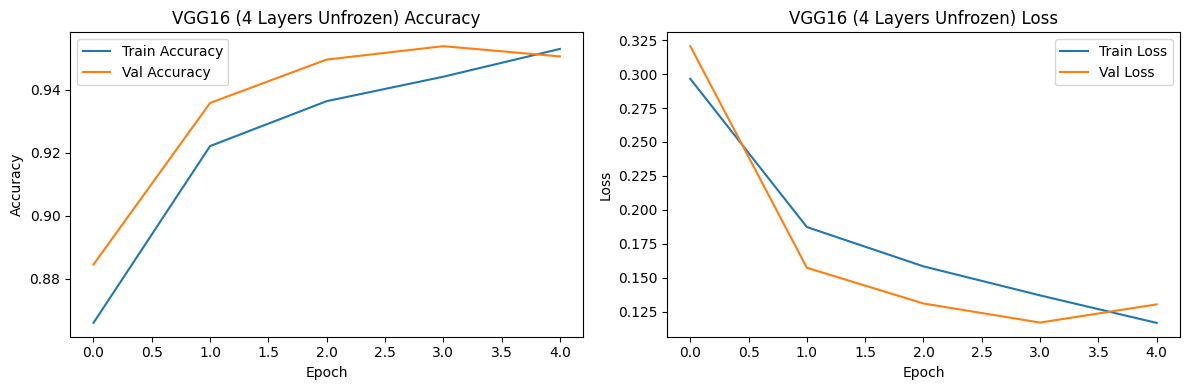

In [40]:
# Evaluation
vgg16_unfrozen_metrics = evaluate_model(
    vgg16_unfrozen,
    "VGG16 (4 Layers Unfrozen)",
    val_generator,
    history_vgg16_unfrozen
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step

Evaluation for MobileNet

Classification Report:
              precision    recall  f1-score   support

        cats       0.98      0.97      0.97      2000
        dogs       0.97      0.98      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



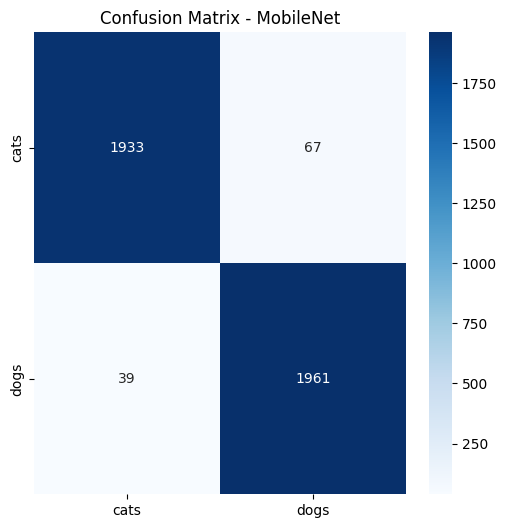

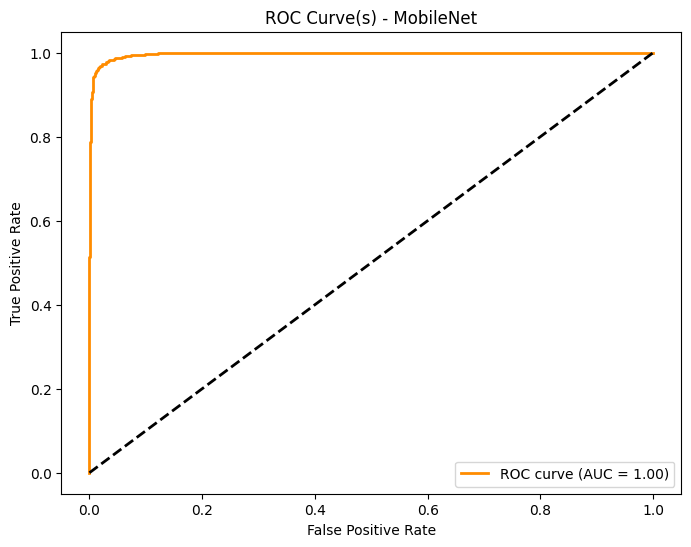

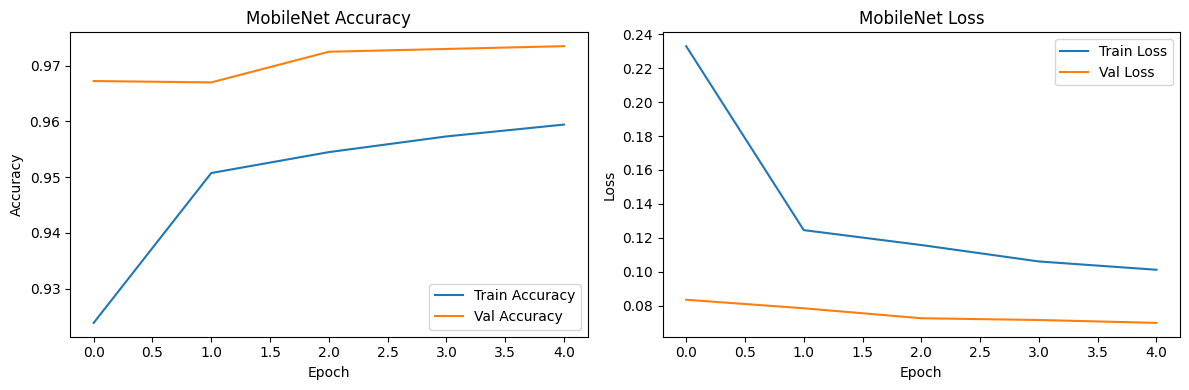

In [41]:
# Evaluation
mobilenet_metrics = evaluate_model(
    mobilenet,
    "MobileNet",
    val_generator,
    history_mobilenet
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step

Evaluation for InceptionV3

Classification Report:
              precision    recall  f1-score   support

        cats       0.97      0.96      0.96      2000
        dogs       0.96      0.97      0.97      2000

    accuracy                           0.96      4000
   macro avg       0.97      0.96      0.96      4000
weighted avg       0.97      0.96      0.96      4000



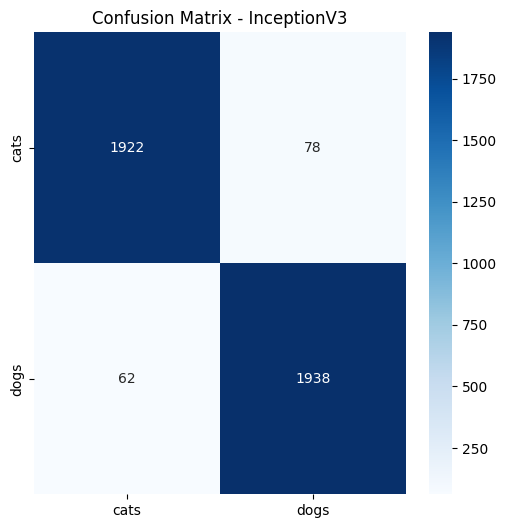

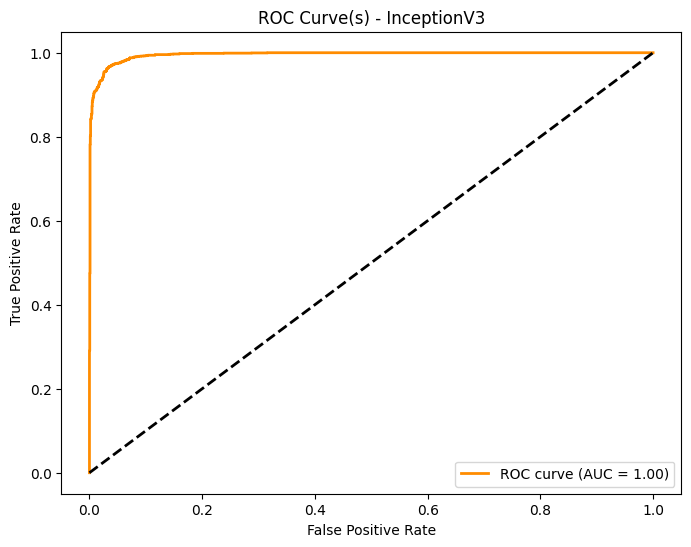

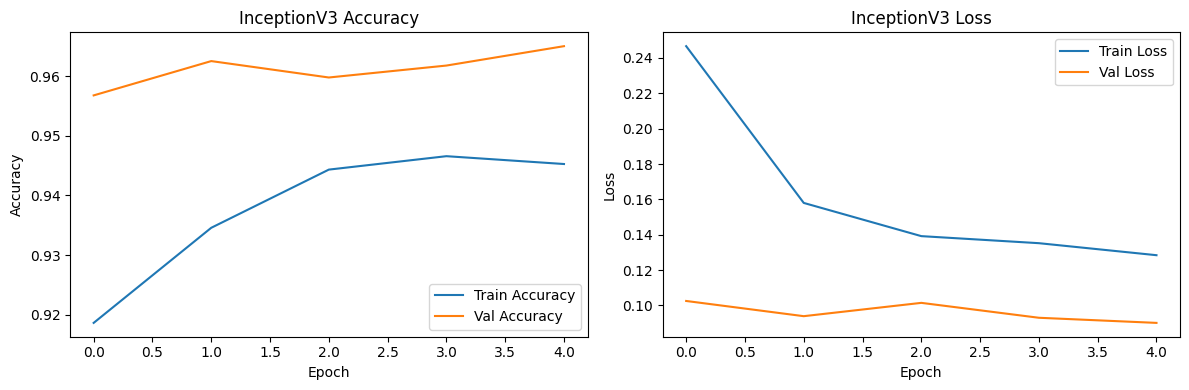

In [42]:
# Evaluation
inception_metrics = evaluate_model(
    inception,
    "InceptionV3",
    val_generator,
    history_inception
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step

Evaluation for LeNet

Classification Report:
              precision    recall  f1-score   support

        cats       0.76      0.82      0.79      2000
        dogs       0.80      0.74      0.77      2000

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



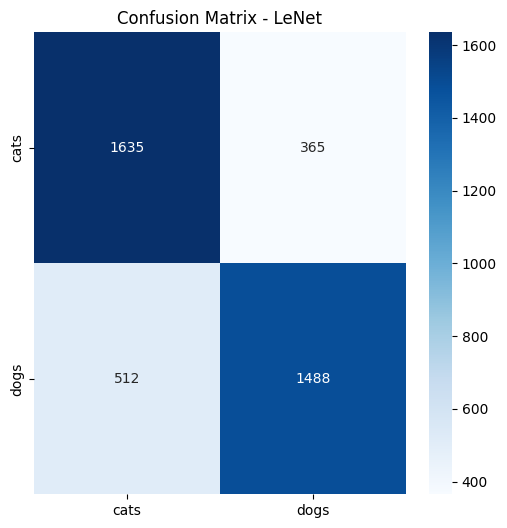

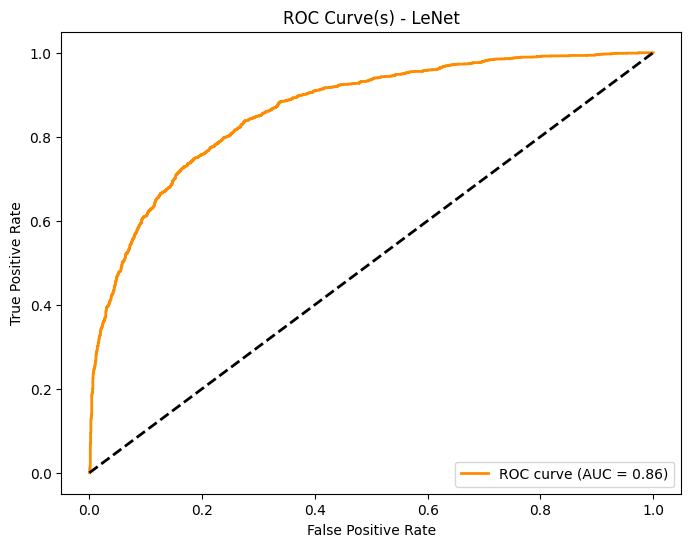

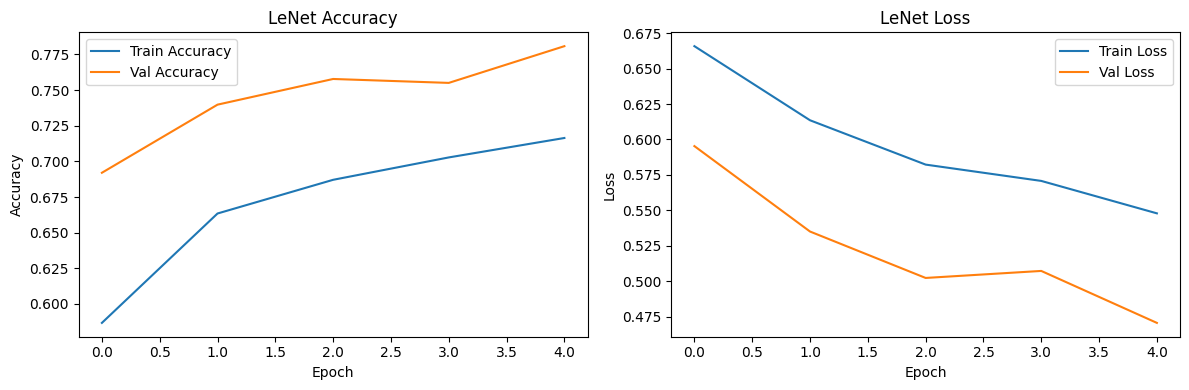

In [43]:
# Evaluation
lenet_metrics = evaluate_model(
    lenet,
    "LeNet",
    val_generator,
    history_lenet
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step

Evaluation for AlexNet

Classification Report:
              precision    recall  f1-score   support

        cats       0.77      0.83      0.80      2000
        dogs       0.81      0.74      0.78      2000

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



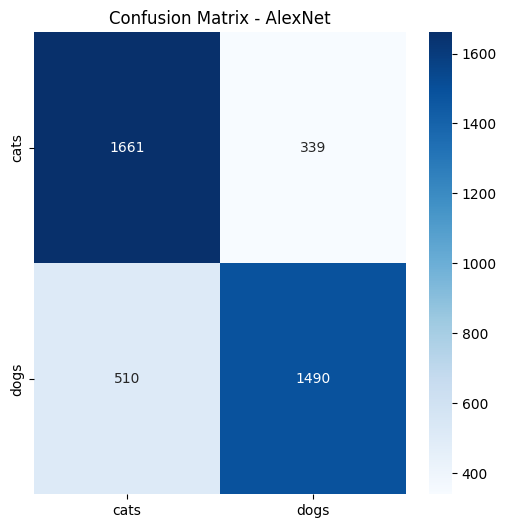

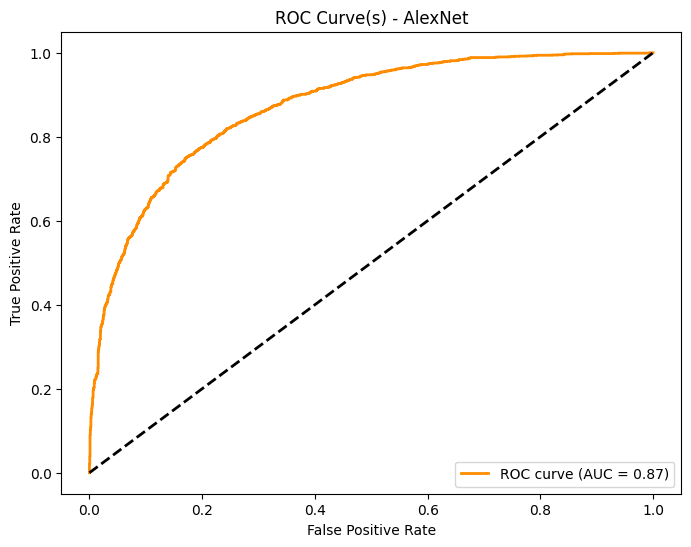

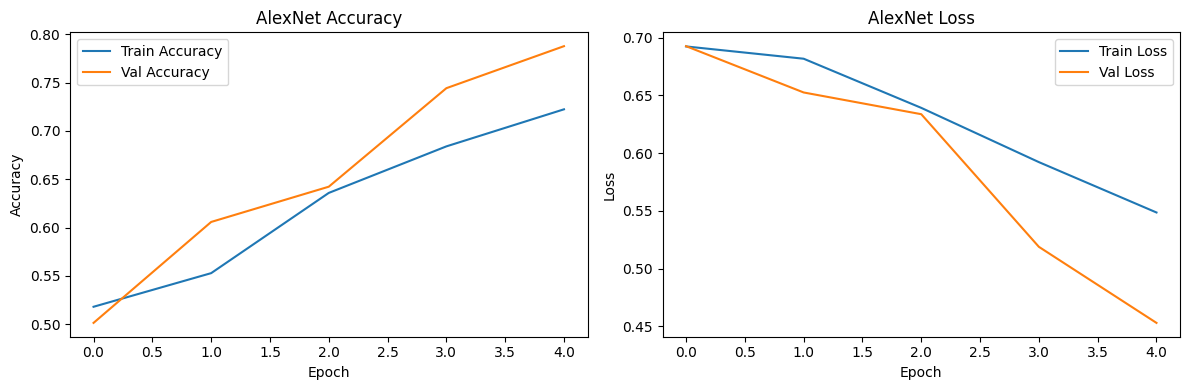

In [44]:
# Evaluation
alexnet_metrics = evaluate_model(
    alexnet,
    "AlexNet",
    val_generator,
    history_alexnet
)

In [28]:
models = {
    'VGG16': vgg16_frozen,
    'VGG16_unfrozen_4_layers': vgg16_unfrozen,# Your pre-trained VGG16 model
    'MobileNet': mobilenet,  # Your pre-trained MobileNet model
    'InceptionV3': inception,  # Your pre-trained InceptionV3 model
    'LeNet': lenet,
    'AlexNet':alexnet

}


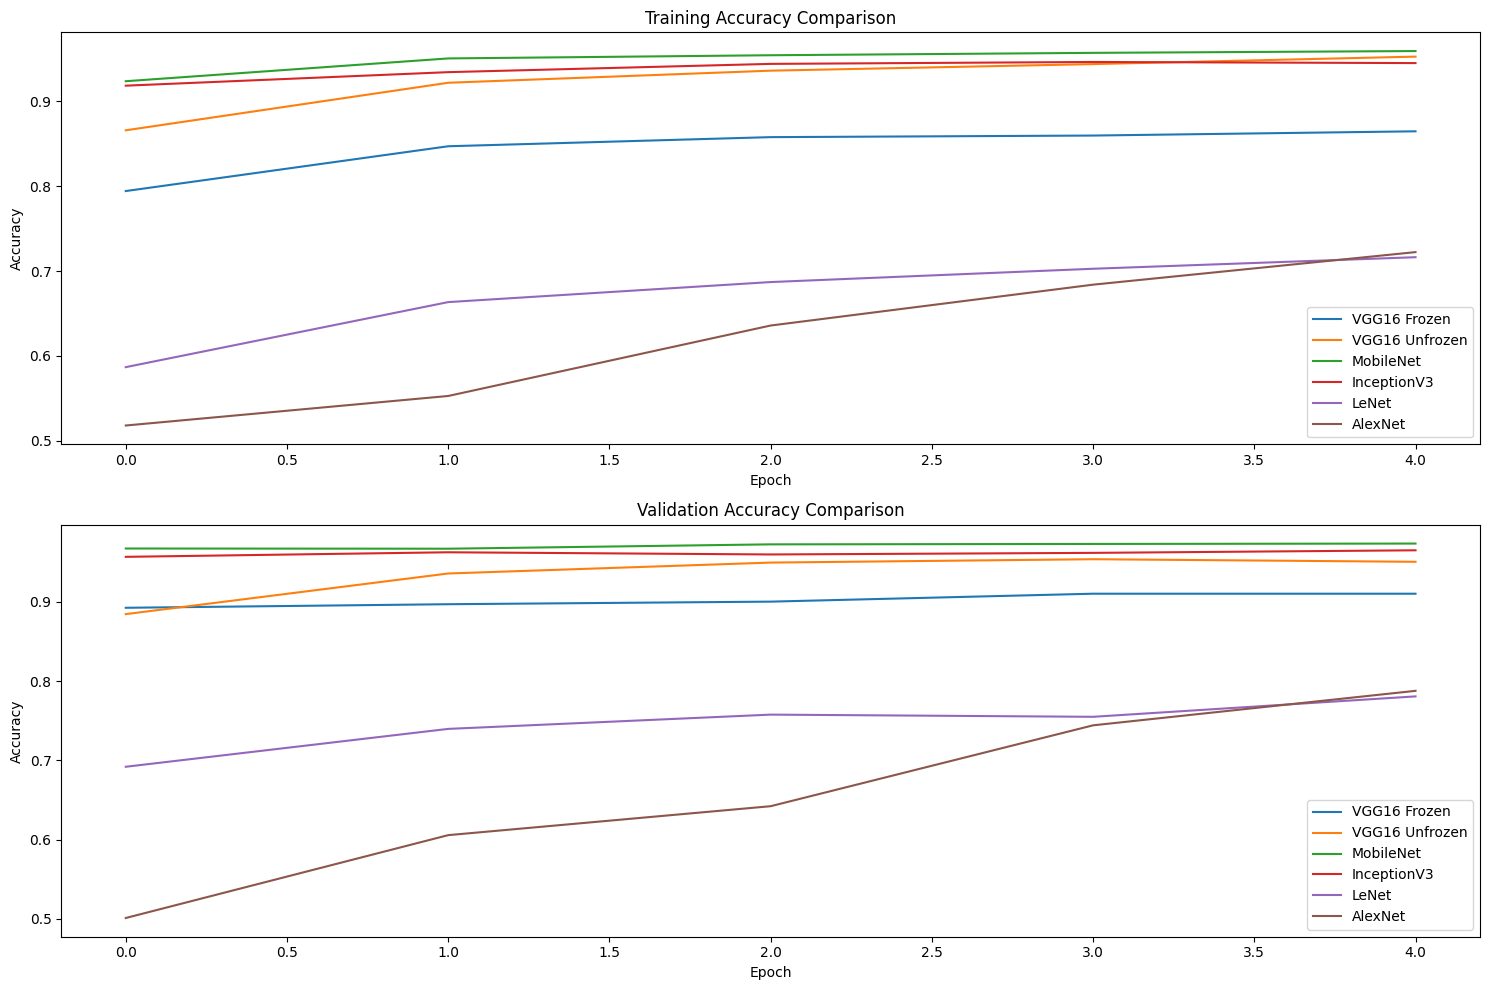

In [33]:
plt.figure(figsize=(15, 10))

# Plot training accuracy
plt.subplot(2, 1, 1)
plt.plot(history_vgg16_frozen.history['accuracy'], label='VGG16 Frozen')
plt.plot(history_vgg16_unfrozen.history['accuracy'], label='VGG16 Unfrozen')
plt.plot(history_mobilenet.history['accuracy'], label='MobileNet')
plt.plot(history_inception.history['accuracy'], label='InceptionV3')
plt.plot(history_lenet.history['accuracy'], label='LeNet')
plt.plot(history_alexnet.history['accuracy'], label='AlexNet')
plt.title('Training Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 1, 2)
plt.plot(history_vgg16_frozen.history['val_accuracy'], label='VGG16 Frozen')
plt.plot(history_vgg16_unfrozen.history['val_accuracy'], label='VGG16 Unfrozen')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNet')
plt.plot(history_inception.history['val_accuracy'], label='InceptionV3')
plt.plot(history_lenet.history['val_accuracy'], label='LeNet')
plt.plot(history_alexnet.history['val_accuracy'], label='AlexNet')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

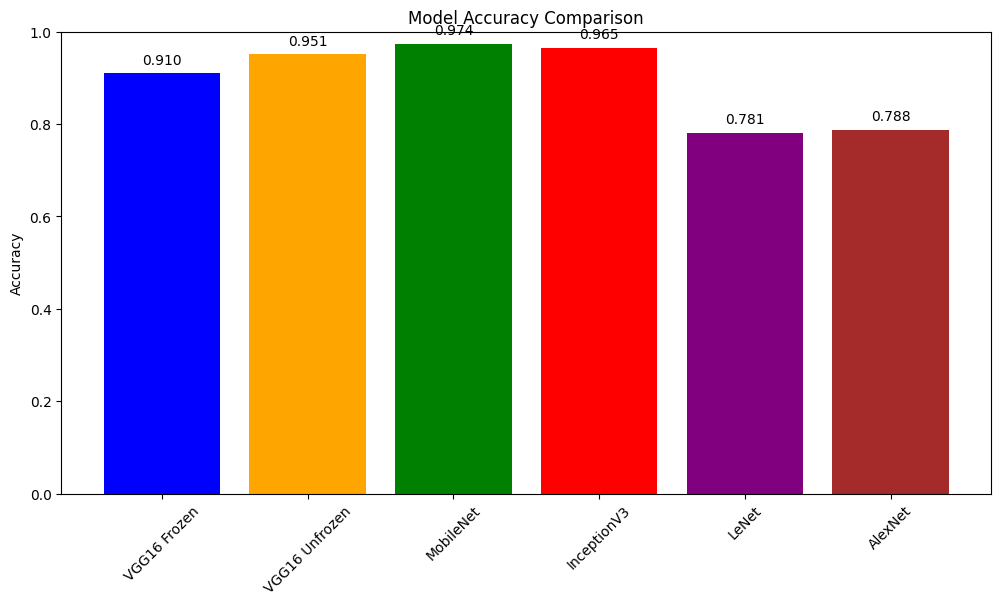

In [32]:
import matplotlib.pyplot as plt
import numpy as np

models = ['VGG16 Frozen', 'VGG16 Unfrozen', 'MobileNet', 'InceptionV3', 'LeNet', 'AlexNet']
accuracies = [vgg16_frozen_metrics['accuracy'],
              vgg16_unfrozen_metrics['accuracy'],
              mobilenet_metrics['accuracy'],
              inception_metrics['accuracy'],
              lenet_metrics['accuracy'],
              alexnet_metrics['accuracy']]

plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step


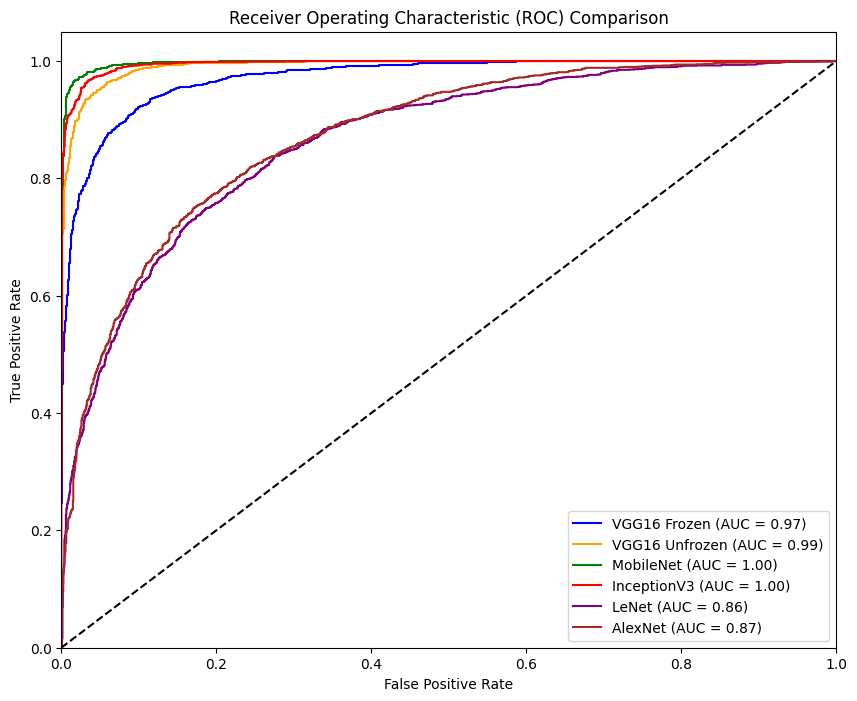

In [34]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'orange', 'green', 'red', 'purple', 'brown'])

# Get predictions for all models
y_true = val_generator.classes
model_predictions = {
    'VGG16 Frozen': vgg16_frozen.predict(val_generator),
    'VGG16 Unfrozen': vgg16_unfrozen.predict(val_generator),
    'MobileNet': mobilenet.predict(val_generator),
    'InceptionV3': inception.predict(val_generator),
    'LeNet': lenet.predict(val_generator),
    'AlexNet': alexnet.predict(val_generator)
}

for i, (name, y_pred) in enumerate(model_predictions.items()):
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=next(colors),
             label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Comparison')
plt.legend(loc="lower right")
plt.show()

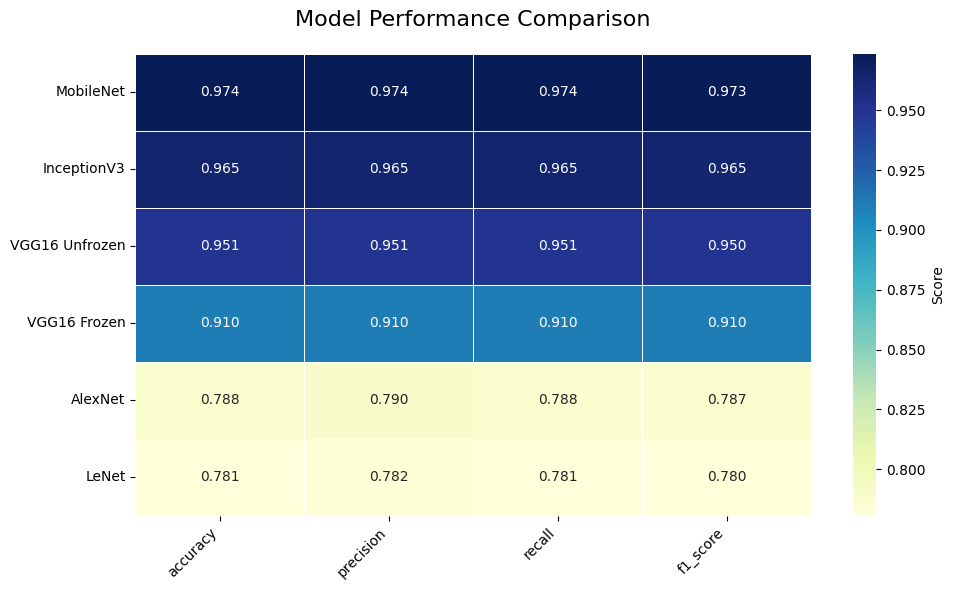

In [47]:
# Prepare the metrics dataframe
metrics_list = [
    vgg16_frozen_metrics,
    vgg16_unfrozen_metrics,
    mobilenet_metrics,
    inception_metrics,
    lenet_metrics,
    alexnet_metrics
]

models = ['VGG16 Frozen', 'VGG16 Unfrozen', 'MobileNet', 'InceptionV3', 'LeNet', 'AlexNet']
metrics_df = pd.DataFrame(metrics_list, index=models)

# Select the metrics to display and sort by accuracy
metrics_to_display = ['accuracy', 'precision', 'recall', 'f1_score']
metrics_df = metrics_df[metrics_to_display].sort_values('accuracy', ascending=False)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df,
            annot=True,
            fmt=".3f",
            cmap="YlGnBu",
            linewidths=.5,
            cbar_kws={'label': 'Score'})

plt.title('Model Performance Comparison', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

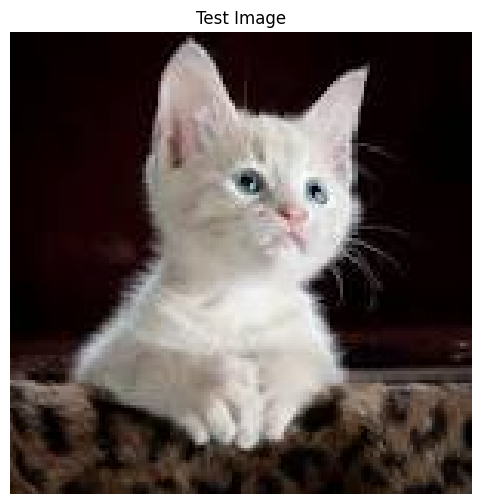


Model Predictions:
Model                Predicted Class      Confidence     
-------------------------------------------------------
VGG16 Frozen         Cat                  1.0000         
VGG16 Unfrozen       Cat                  1.0000         
MobileNet            Cat                  1.0000         
InceptionV3          Cat                  1.0000         
LeNet                Cat                  0.8606         
AlexNet              Cat                  0.9703         


In [46]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

def test_image_on_models(img_path, class_names=['Class 0', 'Class 1']):
    """
    Test a single image on multiple models and display predictions
    Args:
        img_path: Path to the test image
        class_names: List of class names (default ['Class 0', 'Class 1'])
    """
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Display the test image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Test Image')
    plt.show()

    # Get predictions from all models
    results = []
    for name, model in [('VGG16 Frozen', vgg16_frozen),
                       ('VGG16 Unfrozen', vgg16_unfrozen),
                       ('MobileNet', mobilenet),
                       ('InceptionV3', inception),
                       ('LeNet', lenet),
                       ('AlexNet', alexnet)]:
        pred = model.predict(img_array, verbose=0)
        predicted_class = np.argmax(pred[0])
        confidence = np.max(pred[0])
        results.append((name, class_names[predicted_class], confidence))

    # Display results in a clean table format
    print("\nModel Predictions:")
    print("{:<20} {:<20} {:<15}".format('Model', 'Predicted Class', 'Confidence'))
    print("-" * 55)
    for name, pred_class, confidence in results:
        print("{:<20} {:<20} {:<15.4f}".format(name, pred_class, confidence))

# Example usage
test_image_path = '/content/ass5-test-neko.jpg'
test_image_on_models(test_image_path, class_names=['Cat', 'Dog'])  # Replace with your actual class names

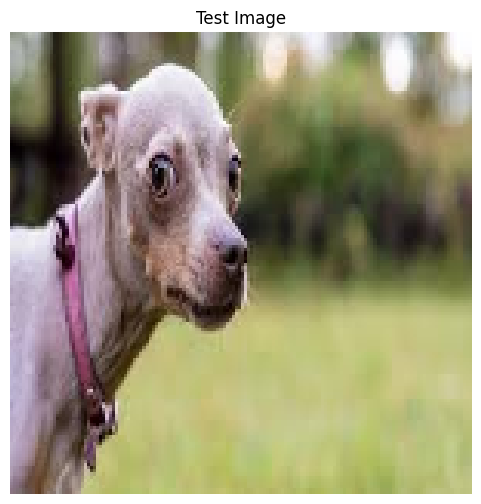


Model Predictions:
Model                Predicted Class      Confidence     
-------------------------------------------------------
VGG16 Frozen         Dog                  0.9998         
VGG16 Unfrozen       Dog                  1.0000         
MobileNet            Dog                  1.0000         
InceptionV3          Dog                  1.0000         
LeNet                Cat                  0.6199         
AlexNet              Dog                  0.7892         


In [48]:
test_image_on_models('/content/dogo.jpg', class_names=['Cat', 'Dog'])  # Replace with your actual class names

# Conclusion 

In this notebook, we compared six diffren  models on dogs-vs-cats for a classification task. MobileNet performed the best with accuracy, precision, recall, and F1-score all around 0.974. InceptionV3 and VGG16 Unfrozen also showed strong performance, while AlexNet and LeNet had the lowest scores (around 0.78). VGG16 Frozen performed moderately well with 0.910 across all metrics. Overall, fine-tuned pre-trained models outperformed older or frozen architectures.